#**Covid-19 Detection Using CNN**

###**Installing & Importing Libraries**

In [ ]:
%%shell
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import opendatasets as od
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import shutil
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Flatten, Conv2D, Dense, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

###**Preparing the files**

In [ ]:
# {"username":"ashleyjejigeorge","key":"2f407cf64a34212d7a8d87a0b4d8d7fd"}
od.download('''https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database''')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ashleyjejigeorge
Your Kaggle Key: ··········


100%|██████████| 778M/778M [00:11<00:00, 69.4MB/s]


In [ ]:
dir_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset'
os.chdir(dir_path)
os.listdir()

['Viral Pneumonia',
 'Normal',
 'Normal.metadata.xlsx',
 'Viral Pneumonia.metadata.xlsx',
 'Lung_Opacity.metadata.xlsx',
 'README.md.txt',
 'COVID',
 'Lung_Opacity',
 'COVID.metadata.xlsx']

In [ ]:
# Deleting files that are not required
!mv 'Viral Pneumonia' Viral_Pneumonia
!mv 'Viral Pneumonia.metadata.xlsx' Viral_Pneumonia.metadata.xlsx
!rm README.md.txt
!rm Viral_Pneumonia.metadata.xlsx
!rm Lung_Opacity.metadata.xlsx
shutil.rmtree('Lung_Opacity')
shutil.rmtree('Viral_Pneumonia')

In [ ]:
os.listdir()

['Normal', 'Normal.metadata.xlsx', 'COVID', 'COVID.metadata.xlsx']

In [ ]:
covid = pd.read_excel('COVID.metadata.xlsx')
covid.head()

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [ ]:
normal = pd.read_excel('Normal.metadata.xlsx')
normal.head()

,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [ ]:
covid['label'] = 1
normal['label'] = 0
covid = covid[['FILE NAME', 'label']]
normal = normal[['FILE NAME', 'label']]
SAMPLE_SIZE = 3616
df_0 = covid.sample(SAMPLE_SIZE, random_state=26)
df_1 = normal.sample(SAMPLE_SIZE, random_state=26)

# concat dataframes
data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# check numbers of each label
data['label'].value_counts()

1    3616
0    3616
Name: label, dtype: int64

In [ ]:
data = shuffle(data)
data.head()

,FILE NAME,label
4853,NORMAL-6646,0
1469,COVID-1922,1
4931,NORMAL-274,0
3336,COVID-2796,1
4011,NORMAL-6619,0


In [ ]:
df_train, df_test = train_test_split(data, test_size=0.20, random_state=26)

print(df_train.shape)
print(df_test.shape)

(5785, 2)
(1447, 2)


In [ ]:
df_train['label'].value_counts()

1    2895
0    2890
Name: label, dtype: int64

In [ ]:
df_test['label'].value_counts()

0    726
1    721
Name: label, dtype: int64

In [ ]:
os.mkdir('train')
os.mkdir('train/covid')
os.mkdir('train/normal')
os.mkdir('test')
os.mkdir('test/covid')
os.mkdir('test/normal')
os.mkdir('test_data')
os.mkdir('train_data')
os.listdir()

['Normal',
 'train',
 'Normal.metadata.xlsx',
 'COVID',
 'test',
 'COVID.metadata.xlsx',
 'test_data',
 'train_data']

In [ ]:
# Expriment

train_list = list(df_train['FILE NAME'])
test_list = list(df_test['FILE NAME'])
train_dir = 'train_data'
test_dir = 'test_data'

# Copy images to train_dir folder
for image in train_list:
    
    # add .png extension 
    filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == image, ['label']].values)
    
    # match the target with the folder's name and source path of the image
    if target == 1:
        label = 'covid'
        src = os.path.join('COVID/images', filename)
        
    if target == 0:
        label = 'normal'
        # As 'FILE NAME's in .xlsx file begins with 'NORMAL' but real file names begin with 'Normal'
        filename = filename.capitalize()
        src = os.path.join('Normal/images', filename)

    # destination path to image
    dst = os.path.join(train_dir, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

# Copy images to test_dir folder
for image in test_list:
    
    # add .png extension 
    filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == image, ['label']].values)
    
    # match the target with the folder's name and source path of the image
    if target == 1:
        label = 'covid'
        src = os.path.join('COVID/images', filename)
        
    if target == 0:
        label = 'normal'
        # As 'FILE NAME's in .xlsx file begins with 'NORMAL' but real file names begin with 'Normal'
        filename = filename.capitalize()
        src = os.path.join('Normal/images', filename)

    # destination path to image
    dst = os.path.join(test_dir, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [ ]:
train_list = list(df_train['FILE NAME'])
test_list = list(df_test['FILE NAME'])
train_dir = 'train'
test_dir = 'test'

# Copy images to train_dir folder
for image in train_list:
    
    # add .png extension 
    filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == image, ['label']].values)
    
    # match the target with the folder's name and source path of the image
    if target == 1:
        label = 'covid'
        src = os.path.join('COVID/images', filename)
        
    if target == 0:
        label = 'normal'
        # As 'FILE NAME's in .xlsx file begins with 'NORMAL' but real file names begin with 'Normal'
        filename = filename.capitalize()
        src = os.path.join('Normal/images', filename)

    # destination path to image
    dst = os.path.join(train_dir, label, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

# Copy images to test_dir folder
for image in test_list:
    
    # add .png extension 
    filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == image, ['label']].values)
    
    # match the target with the folder's name and source path of the image
    if target == 1:
        label = 'covid'
        src = os.path.join('COVID/images', filename)
        
    if target == 0:
        label = 'normal'
        filename = filename.capitalize()
        src = os.path.join('Normal/images', filename)
        
    # destination path to image
    dst = os.path.join(test_dir, label, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [ ]:
print(len(os.listdir('train/covid')))
print(len(os.listdir('train/normal')))

2895
2890


In [ ]:
print(len(os.listdir('test/covid')))
print(len(os.listdir('test/normal')))

721
726


###**Generating Train & Test Data**

In [ ]:
train_data_dir = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/train/'
test_data_dir = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/test/'
img_width , img_height = [224,224]
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

Found 5785 images belonging to 2 classes.
Found 1447 images belonging to 2 classes.


## **Building The Model**

In [ ]:
INIT_LR = 1e-3
EPOCHS = 30
BS = 8

# load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten1")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.6)(headModel)
headModel = Flatten(name="flatten2")(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
history = model.fit(train_generator,
                    validation_data=test_generator,
                    use_multiprocessing=True,
                    workers=6, epochs=5)

Epoch 1/5
362/362 [==============================] - 4598s 13s/step - loss: 0.5171 - accuracy: 0.7468 - val_loss: 0.4585 - val_accuracy: 0.7899
Epoch 2/5
362/362 [==============================] - 4504s 12s/step - loss: 0.4284 - accuracy: 0.8095 - val_loss: 0.3791 - val_accuracy: 0.8286
Epoch 3/5
362/362 [==============================] - 4488s 12s/step - loss: 0.3814 - accuracy: 0.8322 - val_loss: 0.3551 - val_accuracy: 0.8341
Epoch 4/5
362/362 [==============================] - 4458s 12s/step - loss: 0.3626 - accuracy: 0.8429 - val_loss: 0.3523 - val_accuracy: 0.8452
Epoch 5/5
362/362 [==============================] - 4451s 12s/step - loss: 0.3524 - accuracy: 0.8437 - val_loss: 0.3159 - val_accuracy: 0.8576


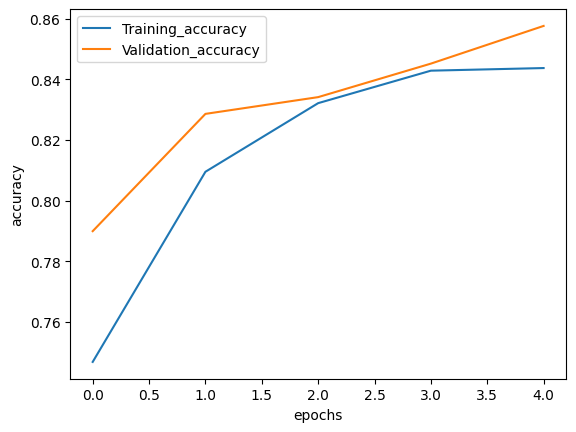

In [ ]:
accs = history.history['accuracy']
val_accs = history.history['val_accuracy']

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()